In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import scipy.sparse as sparse
import pickle

from itertools import chain
from pathlib import *
from math import ceil
from sqlalchemy import create_engine

from helper import *
from tree_weight import *
from time import time
from main import make_graph_from_tree
from multiprocessing import *

from typing import List
%matplotlib inline

In [16]:
image_folder = 'graphs/'
tree = 'benchmark_models/p1f/trees/08.sqlite'
info_df = to_df(tree, 'info').set_index('NodeID')
nodes_df = to_df(tree, 'nodes').set_index('NodeID')
map_dict = {}

print(nodes_df.shape)

# if 'SubtreeSize' not in nodes_df:
#     calculate_subtree_size(nodes_df)
#     to_sqlite(nodes_df, tree)

# valid_df = nodes_df[nodes_df['Status'] != 3]

def get_split_var(row, mappings=None):
    node_idx = row.name
    par_idx = valid_df.loc[node_idx, 'ParentID']
    if par_idx == - 1:
        return None
    cands, _, par_domain, children_domain = find_split_variable(par_idx, valid_df, info_df, mappings)
    return cands[0] if len(cands) == 1 else None

def get_parent_column(column: str, df: pd.DataFrame) -> pd.Series:
    has_root = 1 if 0 == df.index[0] else 0
    j = df.iloc[has_root:, :].reset_index().set_index('ParentID')[['NodeID', column]]
    j.loc[:, column] = df.loc[df.iloc[has_root:, :]['ParentID'], column]    
    return j.reset_index().set_index('NodeID')[column]
    
# valid_df.loc[:, 'SplitVariable'] = valid_df.apply(get_split_var, axis=1, mappings=map_dict)
# valid_df.loc[:, 'SubtreeSizeWeight'] = valid_df['SubtreeSize'] / get_parent_column('SubtreeSize', valid_df)
# valid_df.loc[:, 'SearchSpaceWeight'] = valid_df['SearchSpaceNodeWeight'] / get_parent_column('SearchSpaceNodeWeight', valid_df)

(207, 12)


In [17]:
nodes_df

,ParentID,Alternative,NKids,Status,Label,DFSOrdering,DomainNodeWeight,NodeWeight,SearchSpaceNodeWeight,SubtreeSize,SubtreeSizeNodeWeight,UniformNodeWeight
NodeID,,,,,,,,,,,,
0,-1,-1,2,2,,0,1.000000e+00,1.000000,1.000000,133,1.000000e+00,1.000000
1,0,0,2,2,X_INTRODUCED_779_[1] = 2,1,1.796506e-03,0.500000,0.142857,131,5.000000e-01,0.500000
2,0,1,0,1,X_INTRODUCED_779_[1] != 2,132,9.982035e-01,0.500000,0.857143,1,5.000000e-01,0.500000
3,1,0,2,2,X_INTRODUCED_779_[3] = 4,2,2.011632e-06,0.250000,0.028571,37,2.500000e-01,0.250000
4,1,1,2,2,X_INTRODUCED_779_[3] != 4,39,1.794495e-03,0.250000,0.114286,93,2.500000e-01,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
202,199,1,0,3,,-1,0.000000e+00,0.000000,0.000000,0,0.000000e+00,0.000000
203,201,0,2,2,X_INTRODUCED_779_[33] = 6,129,1.012788e-05,0.007812,0.009524,3,2.672364e-06,0.007812
204,201,1,0,3,,-1,0.000000e+00,0.000000,0.000000,0,0.000000e+00,0.000000


/home/longdang/WorkStation/University/cpTreeEstimation/main.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


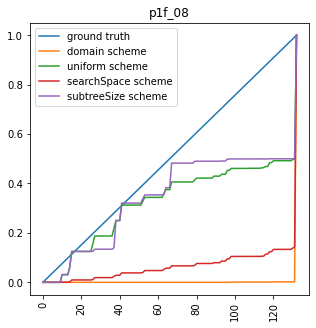

In [15]:
image_folder = 'graphs/'
tree = 'benchmark_models/p1f/trees/08.sqlite'

(fig, ax), nodes_df, info_df, cum_sums = \
        make_graph_from_tree(tree,
            schemes=['domain_scheme', 
                     'uniform_scheme',
                     'searchSpace_scheme',
                     'subtreeSize_scheme'
                    ],
            write_to_sqlite=True,
            save_image=True,
            use_parallel=True,
            assign_in_dfs_order=True
        )

In [37]:
def make_post_ordering_with_func(nodes_df: pd.DataFrame, node_id: int=0, post_ordering: list=None) -> list:
    """
    Return list of node ids in post order, i.e. left subtree - right subtree - root

    We ignored restart nodes.
    """
    if post_ordering is None:
        post_ordering = []

    # base case: current node is a leaf
    if nodes_df.loc[node_id, 'Status'] in {0, 1}:
        return post_ordering

    # else, travel through children
    children = nodes_df[(nodes_df['ParentID'] == node_id) & (nodes_df['Status'] != 3)]\
                .sort_values('Alternative', ascending=True).index
    
    # run recursive algorithm
    for child in children:
        make_post_ordering_with_func(nodes_df, child, post_ordering)
    post_ordering.append((node_id, fit_characteristic(node_id, nodes_df)))


#     if len(post_ordering) == len(nodes_df[nodes_df['Status'] != 3]):
#         assert set(post_ordering) == (set(nodes_df[nodes_df['Status'] != 3].index))
    
    return post_ordering

In [58]:
# %%timeit
# post_ordering_with_func = make_post_ordering_with_func(nodes_df)
fitted_w = pd.DataFrame(post_ordering_with_func, columns=['PostOrdering', 'fitted_w'])
# fitted_w = fitted_w.sort_values('PostOrdering', ascending=True).reset_index(drop=True)['fitted_w']
# y = fitted_w.ewm(alpha=0.7).mean()

In [88]:
assi

Assign weight on trucking 04 with 45100 nodes and search Space scheme:
    - without parallel: 1min 23s ± 1.56 s per loop (mean ± std. dev. of 7 runs, 1 loop each) 
    - with parallel: 54.2 s ± 11.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

    
Issue:
seemes parallel is not getting everything correct?
Maybe since with parallel the dict used by ws is not stable

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Weighting Performance'}>)

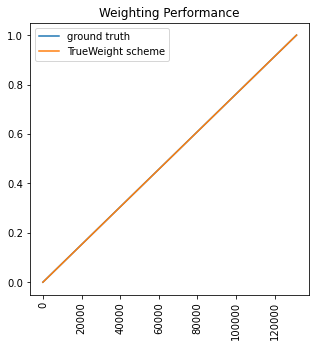

In [10]:
# make real weight scheme with actual subtree sizes to make sure they match true value

valid_df = pd.DataFrame.copy(nodes_df[nodes_df['Status'] != 3])
valid_df['TrueSubtreeWeight'] = valid_df['SubtreeSize'] / (get_parent_column('SubtreeSize', valid_df) - 1)
valid_df.loc[:, 'TrueSubtreeWeight'].fillna(0, inplace=True)

col = range(nodes_df.shape[0])
row = valid_df.reset_index().set_index('ParentID').index.to_list()[1:]
col = valid_df.index.to_list()[1:]
data = valid_df['TrueSubtreeWeight'].values[1:]

weights = sparse.csr_matrix((data, (row, col)), 
            shape=(nodes_df.shape[0], nodes_df.shape[0]))
running = weights

weight_colname = 'TrueNodeWeight'
while np.any((running[0] > 0).data):
    temp = running[0].tocoo()
    col = temp.col[temp.data > 0]
    valid_df.loc[col, weight_colname] = temp.data[temp.data > 0]
    running = running * weights

# assign_weight(nodes_df, 'true_weight', 'TrueNodeWeight',
#     assign_in_dfs_order=False, use_parallel=False)

valid_df.loc[0, 'TrueNodeWeight'] = 1
    
nodes_df.loc[:, 'TrueNodeWeight'] = valid_df['TrueNodeWeight']
nodes_df.loc[:, 'TrueNodeWeight'] = nodes_df['TrueNodeWeight'].fillna(0)

dfs_ordering = valid_df.sort_values('DFSOrdering').index.to_list()
cum_sums = {'TrueWeight': get_cum_weight(valid_df, 'TrueNodeWeight', dfs_ordering)}
plot_goodness(cum_sums)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Weighting Performance'}>)

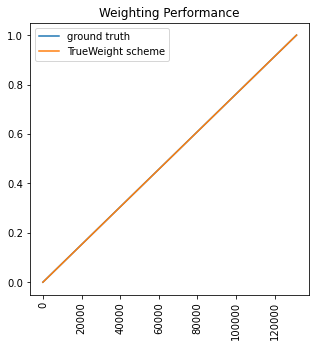

In [4]:
# see if subtree dsizes follow the same characteristic

def fit_characteristic(node_id, nodes_df=None):
    truth = nodes_df[nodes_df['ParentID'] == node_id]['SubtreeSize'].values
    a_s = [truth[i] / truth[i - 1] for i in range(1, len(truth))]
    return np.mean(a_s) if len(a_s) > 0 else 0

# for each parent node and the corresponding children
weights = nodes_df[nodes_df['Status'] == 2].reset_index()['NodeID'].apply(fit_characteristic, nodes_df=nodes_df)
# weighgs = pd.Series(weights)

# valid_df[valid_df['Status'] == 2].reset_index()['NodeID'].apply(fit_characteristic, nodes_df=valid_df)

nodes_df['
- total time: 20min
- make_dfs_ordering: 3m30s
- load info_df: 365ms
- load nodes_df: 404ms
- copy nodes_df: 7.96ms
- assign weights to nodes_df: 7min30s
- assign weights to test_df: 12min26s
- get_cum_weights for nodes_df: 156ms
- get_cum_weights for test_df: 125ms


f(par_idx) -> list[nkids weights]

Simple solution:
    f(par_idx) = 
    x = np.array([(weight**i) for i in range(nodes_df.loc[par_idx, 'NKids'])])
    # normalize x so it adds to 1
    x = x / x.sum()

ON.RETURN.TO.HIGHER LEVEL
    seen_idx.append(node_id)
    new_weight = fit_characteristic_weight(seen_idx) # find weight that best fit the known curve
    weight = alpha * weight + (1  - alpha) * new_weight # exponential decay
    
    

INITIALIZE WEIGHT
    weight = 1 # no drop of subtree size
    

def fit_characteristic_weight(seen_idx, nodes_df):
    
    truth = nodes_df.loc[seen_idx, 'SubtreeSize'].values
    a_s = [truth[i] / truth[i - 1] for i in range(1, len(truth))]
    return np.mean(a_s)
    
given data subtree_s(0..k):
a1 = subtree_s(1) / subtree_s(0)
a2 = subtree_s(2) / subtree_s(1)
a3 = ...

find w that minimizes 1/2(a1..k - w)^2 -> w = mean(a1, a2, a3, a4)


1, 1/w, 1/w^2, 1/w^3, 1/w^4, ... 1/w^n -> normalized -> 1/w^k * 

sum(1, 1/w, 1/w^2, ... 1/w^n) = S
wS = w + 1 + 1/w + .. + 1/w^(n - 1) = w + S - 1/w^n => S(w - 1) = w - 1/w^n = (w - 1/w^n) / (w - 1)

In [ ]:
nodes_df['No